In [38]:
!pip install pytorch_lightning

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/'

# data = np.load(data_path + 'NOICA/P03_01.npy')
# labels_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/class_labels/'
# # labels = np.load(labels_path + 'group_P03_01.npy')
# data = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/Sven_Prp/eeg/eeg_P03_2D.npy")
# labels = np.load('/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/Sven_Prp/group_label/group_P03_2D.npy')
# data = np.transpose(data, (0, 2, 1))

data = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/S01/eeg/P10_01.npy")
labels = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/2D/class_labels/group_P03_2D.npy")

print(data.shape)
print(labels.shape)

(468, 64, 4096)
(78,)


In [6]:
# data = np.load(data, allow_pickle=True)  # Shape: (trials, channels, samples)
# self.labels = np.load(labels, allow_pickle=True)  # Shape: (trials,)

# Convert to PyTorch tensors
data = torch.from_numpy(data).type(torch.float32).to(device)

# self.data = torch.from_numpy(self.data.swapaxes(1, 2)).to(self.device)  # Swap axes to get (n_trials, channels, samples)
labels = torch.from_numpy(labels).type(torch.LongTensor).to(device)  # Convert labels to long tensor
labels = labels - 1  # Subtract 1 to make labels 0-indexed
print(data.shape)  
print(labels.shape)

torch.Size([468, 64, 4096])
torch.Size([468])


In [6]:
"""Save the data for test, val and train seperatley"""
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# np.save("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/Generation_2D/Segmented_data_2D/train/P03train", X_train)
# np.save("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/Generation_2D/Segmented_data_2D/train/P03trainlabels", y_val)
# np.save("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/Generation_2D/Segmented_data_2D/val/P03val", X_val)
# np.save("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/Generation_2D/Segmented_data_2D/val/P03vallabels", y_val)
# np.save("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/Generation_2D/Segmented_data_2D/test/P03test", X_test)
# np.save("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/Generation_2D/Segmented_data_2D/test/P03testlabels", y_test)


In [7]:
print(X_train.shape)
print(y_train.shape)    
print(X_val.shape)  
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(62, 64, 15360)
(62,)
(8, 64, 15360)
(8,)
(8, 64, 15360)
(8,)


## Prepare Data for Classifiation

*   Try segmenting the data further into 1sec epochs
*   Try overlapping window samples
*   Implement Window Sliding


EEGNet requires a Datatype of a 2D format, typically as (batch_size, 1, n_channels, n_timepoints):

Segment epochs into 1s epochs from 8s : (3744,85,512)

## Implementing overlapping time windows with sliding window



In [86]:
# """Downsample the Data - as low pass fiter is already applied at 100Hz which is below the Nyquist freq., we dont have to worry about aliasing the data for the target freq. of 265 Hz """

# from scipy.signal import resample

# # Resample the data from 512 Hz to 256 Hz
# n_samples = data.shape[-1] // 2  # Divide the number of samples by 2 to downsample
# downsampled_data = resample(data, n_samples, axis=-1)
# print(downsampled_data.shape)
# # data = downsampled_data

In [46]:
import numpy as np

def sliding_window_data(data, labels, fs, window_length, overlap):
    """
    Segments data into epochs using a sliding window approach.

    Parameters:
    - data: np.array, shape (num_trials, num_channels, num_samples)
    - labels: np.array, shape (num_trials,)
    - fs: int, Sampling frequency (samples per second)
    - window_length: float, Length of each window in seconds
    - overlap: float, Overlap between consecutive windows (in range [0, 1])

    Returns:
    - segmented_data: np.array, shape (num_windows_total, num_channels, samples_per_window)
    - segmented_labels: np.array, shape (num_windows_total,)
    """
    samples_per_window = int(fs * window_length)  # Number of samples per window
    step_size = int(samples_per_window * (1 - overlap))  # Step size based on overlap

    num_trials, num_channels, num_samples = data.shape
    num_windows_per_trial = (num_samples - samples_per_window) // step_size + 1
    num_windows_total = num_trials * num_windows_per_trial

    # Initialize arrays for segmented data and labels
    segmented_data = np.zeros((num_windows_total, num_channels, samples_per_window))
    segmented_labels = np.zeros(num_windows_total)

    window_index = 0
    for trial in range(num_trials):
        for window in range(num_windows_per_trial):
            start_sample = window * step_size
            end_sample = start_sample + samples_per_window
            segmented_data[window_index, :, :] = data[trial, :, start_sample:end_sample]
            segmented_labels[window_index] = labels[trial]
            window_index += 1

    return segmented_data, segmented_labels

segmented_data_overlap, segmented_labels_overlap = sliding_window_data(data, labels, fs=215, window_length=2, overlap=0)
print("Segmented data shape:", segmented_data_overlap.shape)
print("Segmented labels shape:", segmented_labels_overlap.shape)


Segmented data shape: (0, 15360, 430)
Segmented labels shape: (0,)


## EEGNet Model regular

In [47]:
import numpy as np
import torch
from torch import nn
from torch.nn.functional import elu
import pytorch_lightning as pl

"""
Note: this code is taken from https://github.com/braindecode/braindecode/tree/master/braindecode
which is the implemented EEGNet version from torcheeg.

The model was adapted to be used with the pytorch lightning trainer.

Notes:
- 4D: n_trials, depth, n_channels, n_samples
"""

class EEGNetv4(nn.Module):
    """EEGNet v4 model from Lawhern et al 2018.

    Parameters
    ----------
    in_chans : int

    Notes
    -----
    This implementation is not guaranteed to be correct, has not been checked
    by original authors, only reimplemented from the paper description.

    References
    ----------
    .. [EEGNet4] Lawhern, V. J., Solon, A. J., Waytowich, N. R., Gordon,
       S. M., Hung, C. P., & Lance, B. J. (2018).
       EEGNet: A Compact Convolutional Network for EEG-based
       Brain-Computer Interfaces.
       arXiv preprint arXiv:1611.08024.
    """

    def __init__(
        self,
        #General
        lr = 1e-3,
        one_cycle_lr = True,
        weight_decay = 0.0,
        epochs = 100,
        in_chans = 64,
        n_classes = 6,
        final_conv_length="auto",
        input_window_samples=None,
        #Convolutions and Pooling (depth of spatial conv = F2*D)
        F1=64, # use 64 based on svens paper
        D=2,
        kernel_length=256, ## Filter length/kernel length in paper defined as 1/2 * sf
        pool_mode="max",
        drop_prob=0.25,
        momentum = 0.01,
        **kwargs
    ):
        super().__init__()
        if final_conv_length == "auto":
            assert input_window_samples is not None
        self.in_chans = in_chans
        self.n_classes = n_classes
        self.input_window_samples = input_window_samples
        self.final_conv_length = final_conv_length
        self.pool_mode = pool_mode
        self.F1 = F1
        self.D = D
        self.F2 = D*F1
        self.kernel_length = kernel_length
        self.drop_prob = drop_prob
        self.momentum = momentum
        self.one_cycle_lr = one_cycle_lr
        self.lr = lr
        self.weight_decay = weight_decay
        pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[self.pool_mode]
        self.loss = nn.NLLLoss() #EEGNet uses a log softmax layer. Therefore, using a NLLLoss() equates to CrossEntropyLoss()
        self.epochs = epochs

        self.ensuredims = Ensure4d() # from [b c t] to [b c t 1]
        self.dimshuffle = Expression(_transpose_to_b_1_c_0) # from [b c t 1] to [b 1 c t] --> first conv over temporal dim with kernel_length
        self.conv_temporal = nn.Conv2d(
            in_channels = 1,
            out_channels = self.F1,
            kernel_size = (1, self.kernel_length),
            stride = 1,
            bias = False,
            padding = (0, self.kernel_length // 2),
            )
        self.bnorm_temporal = nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3)
        self.conv_spatial = Conv2dWithConstraint(
            self.F1,
            self.F1 * self.D,
            (self.in_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=self.F1,
            padding=(0, 0),
            )
        self.bnorm_1 = nn.BatchNorm2d(self.F1 * self.D, momentum=self.momentum, affine=True, eps=1e-3)
        self.elu_1 = Expression(elu)   ##CHANGE
        self.pool_1 = pool_class(kernel_size=(1, 4), stride=(1, 4))
        self.drop_1 = nn.Dropout(p=self.drop_prob)
        self.conv_separable_depth = nn.Conv2d(
            self.F1 * self.D,
            self.F1 * self.D,
            (1, 32), ## 16 to 32
            stride=1,
            bias=False,
            groups=self.F1 * self.D,
            padding=(0, 32 // 2), ## 16 to 32
            )
        self.conv_separable_point = nn.Conv2d(
            self.F1 * self.D,
            self.F2,
            (1, 1),
            stride=1,
            bias=False,
            padding=(0, 0),
            )
        self.bnorm_2 = nn.BatchNorm2d(self.F2, momentum=self.momentum, affine=True, eps=1e-3)
        self.elu_2 = Expression(elu)  ##CHANGE
        self.pool_2 = pool_class(kernel_size=(1, 8), stride=(1, 8))
        self.drop_2 = nn.Dropout(p=self.drop_prob)

        #The following tests the output dimensions to pass the right dimensions to the classifier head
        out = self.partial_forward(
                torch.ones(
                (1, self.in_chans, self.input_window_samples, 1),
                dtype=torch.float32
                )
            )
        n_out_virtual_chans = out.cpu().data.numpy().shape[2]
        if self.final_conv_length == "auto":
            n_out_time = out.cpu().data.numpy().shape[3]
            self.final_conv_length = n_out_time
        self.conv_classifier = nn.Conv2d(
            self.F2,
            self.n_classes,
            (n_out_virtual_chans, self.final_conv_length),
            bias=True,
            )
        self.softmax = nn.LogSoftmax(dim=1)
        # Transpose time back in third dimension (axis=2)
        self.permute_back = Expression(_transpose_1_0)
        self.squeeze = Expression(squeeze_final_output)
        _glorot_weight_zero_bias(self) #Initialize weights

    def partial_forward(self, x): #for a sample of [1 8 500] and kernel_size=128
        #Used to initially determine the input dimensions to the classifier head
        x = self.ensuredims(x) # [1 8 500 1]
        x = self.dimshuffle(x) # [1 1 8 500]
        x = self.conv_temporal(x) # [1 8 8 501]
        x = self.bnorm_temporal(x) # [1 8 8 501]
        x = self.elu_1(x) # [1 8 8 501]
        x = self.conv_spatial(x) # [1 16 1 501]
        x = self.bnorm_1(x) # [1 16 1 501]
        x = self.elu_1(x) # [1 16 1 501] 
        x = self.pool_1(x) # [1 16 1 125]
        x = self.drop_1(x) # [1 16 1 125]
        x = self.conv_separable_depth(x) # [1 16 1 126]
        x = self.conv_separable_point(x) # [1 16 1 126]
        x = self.bnorm_2(x) # [1 16 1 126]
        x = self.elu_2(x) # [1 16 1 126]
        x = self.pool_2(x) # [1 16 1 15]
        x = self.drop_2(x) # [1 16 1 15]
        return x

    def forward(self, x):
        x = self.partial_forward(x) # [1 16 1 15] #outputs bs x F2 x 1 x 15 (128*15)
        x = self.conv_classifier(x) # [1 20 1 1]
        x = self.softmax(x) # [1 20 1 1]
        x = self.permute_back(x) # [1 20 1 1]
        x = self.squeeze(x) # [1 20]
        return x

    # def configure_optimizers(self):
    #     optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay = self.weight_decay)
    #     return optimizer
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params = self.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        if self.one_cycle_lr:
            one_cycle = torch.optim.lr_scheduler.OneCycleLR(
                    optimizer = optimizer,
                    max_lr = self.lr,
                    total_steps = len(self.trainer.datamodule.train_dataloader()) * self.epochs,
                    # epochs = self.epochs, ## CHANGE thsi
                    # steps_per_epoch = self.trainer.estimated_stepping_batches // self.epochs, #CHANGE this
                    cycle_momentum = True
                    )
            # ##CHANGE
            # fine_tuning = torch.optim.lr_scheduler.ReduceLROnPlateau(
            #     self.optimizer,
            #     mode = "min",
            #     factor = 0.5, #factor by which lr will be reduced
            #     patience = 4 #num epochs with no improvement after which lr will be reduced
            # )
            # fine_tuning = torch.optim.lr_scheduler.ConstantLR(
            #     self.optimizer,
            #     factor = 0.8 #factor by which lr will be reduced
            #     )
            # self.scheduler = torch.optim.lr_scheduler.SequentialLR(
            #     optimizer = self.optimizer,
            #     schedulers=[one_cycle, fine_tuning],
            #     milestones = [len(self.trainer.datamodule.train_dataloader()) * 60] #For 60 epochs
            #     )

            lr_scheduler = {
                "scheduler": one_cycle, #lr
                "interval": "step",
                "name": "Learning Rate Scheduling"
            }
            return [optimizer], [lr_scheduler]
        else:
            return [optimizer]

#Helper functions and classes
def _transpose_to_b_1_c_0(x):
    return x.permute(0, 3, 1, 2)

def _transpose_1_0(x):
    return x.permute(0, 1, 3, 2)

def _glorot_weight_zero_bias(model):
    """Initalize parameters of all modules by initializing weights with
    glorot
     uniform/xavier initialization, and setting biases to zero. Weights from
     batch norm layers are set to 1.

    Parameters
    ----------
    model: Module
    """
    for module in model.modules():
        if hasattr(module, "weight") and not "NLLLoss" in module.__class__.__name__:
            if not ("BatchNorm" in module.__class__.__name__):
                nn.init.xavier_uniform_(module.weight, gain=1)
            else:
                nn.init.constant_(module.weight, 1)
        if hasattr(module, "bias"):
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

def squeeze_final_output(x):
    """Removes empty dimension at end and potentially removes empty time
     dimension. It does  not just use squeeze as we never want to remove
     first dimension.

    Returns
    -------
    x: torch.Tensor
        squeezed tensor
    """
    assert x.size()[3] == 1
    x = x[:, :, :, 0]
    if x.size()[2] == 1:
        x = x[:, :, 0]
    return x

class Conv2dWithConstraint(nn.Conv2d):
    """Conv2d with weight constraint."""
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)

class Expression(nn.Module):
    """Compute given expression on forward pass.

    Parameters
    ----------
    expression_fn : callable
        Should accept variable number of objects of type
        `torch.autograd.Variable` to compute its output.
    """

    def __init__(self, expression_fn):
        super(Expression, self).__init__()
        self.expression_fn = expression_fn

    def forward(self, *x):
        return self.expression_fn(*x)

    def __repr__(self):
        if hasattr(self.expression_fn, "func") and hasattr(
            self.expression_fn, "kwargs"
        ):
            expression_str = "{:s} {:s}".format(
                self.expression_fn.func.__name__, str(self.expression_fn.kwargs)
            )
        elif hasattr(self.expression_fn, "__name__"):
            expression_str = self.expression_fn.__name__
        else:
            expression_str = repr(self.expression_fn)
        return (
            self.__class__.__name__ +
            "(expression=%s) " % expression_str
        )

class Ensure4d(nn.Module):
    def forward(self, x):
        while len(x.shape) < 4:
            x = x.unsqueeze(-1)
        return x

In [10]:

# # This code is used for the EEG ChannelNet and is based on code from the following source:
# # Title: EEG Visual Classification
# # Author: PerceiveLab
# # URL: https://github.com/perceivelab/eeg_visual_classification/blob/main/models/EEGChannelNet.py
# # Date Accessed: 23.07.2023
# # This is the model presented in the work: S. Palazzo, C. Spampinato, I. Kavasidis, D. Giordano, J. Schmidt, M. Shah, Decoding Brain Representations by
# # Multimodal Learning of Neural Activity and Visual Features,  IEEE TRANSACTIONS ON PATTERN ANALYSIS AND MACHINE INTELLIGENCE, 2020, doi: 10.1109/TPAMI.2020.2995909
# # Note the model is adapted to work with the general pipeline used in this study (pytorch lightning and wandb for logging, and reduction of input channels)
# # Additionally the optimizer was integrated into the model with the default values found in the authors' respository

# from typing import Any
# import torch
# import torch.nn as nn


# class FeaturesExtractor(nn.Module):
#     def __init__(self, in_channels, temp_channels, out_channels, input_width, in_height,
#                  temporal_kernel, temporal_stride, temporal_dilation_list, num_temporal_layers,
#                  num_spatial_layers, spatial_stride, num_residual_blocks, down_kernel, down_stride,
#                  dropout):
#         super().__init__()

#         self.temporal_block = TemporalBlock(
#             in_channels, temp_channels, num_temporal_layers, temporal_kernel, temporal_stride, temporal_dilation_list, input_width, dropout
#         )

#         self.spatial_block = SpatialBlock(
#             temp_channels * num_temporal_layers, out_channels, num_spatial_layers, spatial_stride, in_height, dropout
#         )

#         self.res_blocks = nn.ModuleList([
#             nn.Sequential(
#                 ResidualBlock(
#                     out_channels * num_spatial_layers, out_channels * num_spatial_layers
#                 ),
#                 ConvLayer2D(
#                     out_channels * num_spatial_layers, out_channels * num_spatial_layers, down_kernel, down_stride, 0, 1, dropout
#                 )
#             ) for i in range(num_residual_blocks)
#         ])

#         self.final_conv = ConvLayer2D(
#             out_channels * num_spatial_layers, out_channels, down_kernel, 1, 0, 1, dropout
#         )

#     def forward(self, x):
#         out = self.temporal_block(x) #1x40x8x250
#         out = self.spatial_block(out) #1x150x4x250
#         if len(self.res_blocks) > 0:
#             for res_block in self.res_blocks:
#                 out = res_block(out)
#         out = self.final_conv(out)
#         return out

# class ChannelNet(base_model):
#     '''The model for EEG classification.
#     The input is a tensor where each row is a channel the recorded signal and each colums is a time sample.
#     The model performs different 2D to extract temporal e spatial information.
#     The output is a vector of classes where the maximum value is the predicted class.
#     Args:
#         in_channels: number of input channels
#         temp_channels: number of features of temporal block
#         out_channels: number of features before classification
#         num_classes: number possible classes
#         embedding_size: size of the embedding vector
#         input_width: width of the input tensor (necessary to compute classifier input size)
#         input_height: height of the input tensor (necessary to compute classifier input size)
#         temporal_dilation_list: list of dilations for temporal convolutions, second term must be even
#         temporal_kernel: size of the temporal kernel, second term must be even (default: (1, 32))
#         temporal_stride: size of the temporal stride, control temporal output size (default: (1, 2))
#         num_temp_layers: number of temporal block layers
#         num_spatial_layers: number of spatial layers
#         spatial_stride: size of the spatial stride
#         num_residual_blocks: the number of residual blocks
#         down_kernel: size of the bottleneck kernel
#         down_stride: size of the bottleneck stride
#         '''
#     def __init__(self, in_channels=1, temp_channels=10, out_channels=50, num_classes=20, embedding_size=1000,
#                  input_width=500, input_height=8, temporal_dilation_list=[(1,1),(1,2),(1,4),(1,8),(1,16)],
#                  temporal_kernel=(1,33), temporal_stride=(1,2),num_temp_layers=4,num_spatial_layers=4,
#                  spatial_stride=(2,1), num_residual_blocks=2, down_kernel=(1,3), down_stride=2,
#                  dropout = 0.5, lr = 0.001, one_cycle_lr = False, epochs = 100, **kwargs):
#         super().__init__()
#         self.lr = lr
#         self.one_cycle_lr = one_cycle_lr
#         self.epochs = epochs
#         self.encoder = FeaturesExtractor(in_channels, temp_channels, out_channels, input_width, input_height,
#                                      temporal_kernel, temporal_stride,temporal_dilation_list, num_temp_layers,
#                                      num_spatial_layers, spatial_stride, num_residual_blocks, down_kernel, down_stride,
#                                      dropout
#                                      )

#         encoding_size = self.encoder(torch.zeros(1, in_channels, input_height, input_width)).contiguous().view(-1).size()[0]

#         self.classifier = nn.Sequential(
#             nn.Linear(encoding_size, num_classes),
#             # nn.ReLU(True),
#             # nn.Linear(embedding_size, num_classes),
#         )

#     def forward(self, x):
#         out = self.encoder(x.unsqueeze(1))
#         out = out.view(x.size(0), -1) #bsx50x3x59 -> bsx8850
#         out = self.classifier(out) #bsx8850 -> bsx1000 -> bsx20
#         return out

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(params = self.parameters(), lr = self.lr)#, weight_decay = self.weight_decay)
#         if self.one_cycle_lr:
#             lr = torch.optim.lr_scheduler.OneCycleLR(
#                 optimizer = optimizer,
#                 max_lr = self.lr,
#                 total_steps = len(self.trainer.datamodule.train_dataloader()) * self.epochs,
#                 # epochs = self.epochs,
#                 # steps_per_epoch = self.trainer.estimated_stepping_batches // self.epochs,
#                 cycle_momentum = True
#                 )

#             lr_scheduler = {
#                 "scheduler": lr,
#                 "interval": "step",
#                 "name": "Learning Rate Scheduling"
#             }
#             return [optimizer], [lr_scheduler]
#         else:
#             return [optimizer]


# Hyperparameter Check with Weights and Biases




In [48]:
!pip install wandb
!pip install onnx
import onnx
import os
import wandb

os.environ['WANDB_API_KEY'] = 'e1d04737bfba884150d852595cab76060de2a6e5'
os.environ['WANDB_NOTEBOOK_NAME']= "Copy_of_EEGNet_Classification.ipynb"

# Manually set  API key or use another method as shown above
# api_key = "e1d04737bfba884150d852595cab76060de2a6e5"
# wandb.login(key=api_key)

wandb.login()

True

In [12]:
sweep_config = dict(
    method='random',
    parameters=dict(
        epochs=dict(values=[100]),
        batch_size = dict(values=[32]),
        drop_prob=dict(values=[0.25]), # 0.5 increase for overfitting
        pool_mode=dict(values=['max']), # mean
        lr=dict(distribution='log_uniform_values', min=0.0001, max=0.1),
        weight_decay = dict(values=[0.000]),
        # window_length = dict(values=[1,2,4,8]),
        # overlap = dict(values=[0.1,0.2,0.5]),
        F1=dict(values=[64]),
        D=dict(values=[2])
    )
)
sweep_id = wandb.sweep(sweep_config, project="eeg-classification")


Create sweep with ID: otgw413p
Sweep URL: https://wandb.ai/constanzealbrecht-eth-z-rich/eeg-classification/sweeps/otgw413p


In [26]:
 # Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # y_true = y_true.view(-1) # Flatten y_true if it's not already 1D
    # y_pred = y_pred.view(-1) # Flatten y_pred if it's not already 1D
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Hyperparameter Optimization with Validation Set

In [27]:
data.shape

(78, 15360, 64)

In [33]:
from sklearn.model_selection import train_test_split
import torch
from scipy.signal import resample
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import argparse

def make(config):
    # n_samples = data.shape[-1] // 2  # Divide the number of samples by 2 to downsample to 256 Hz 
    # downsampled_data = resample(data, n_samples, axis=-1)
    # print(downsampled_data.shape)
    # data = downsampled_data
    data = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/Sven_Prp/eeg/eeg_P03_2D.npy")
    print(data.shape)
    labels = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/Sven_Prp/group_label/group_P03_2D.npy")
    print(labels.shape)

    fs = 512
    window_length =2 #config["window_length"]
    overlap = 0 #config["overlap"]

    # for segments of data
    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train,y_train = sliding_window_data(X_train, y_train, fs=fs, window_length=window_length, overlap=overlap)
    X_val,y_val = sliding_window_data(X_val, y_val, fs=fs, window_length=window_length, overlap=overlap)
    X_test,y_test = sliding_window_data(X_test, y_test, fs=fs, window_length=window_length, overlap=overlap)


    X_train = torch.from_numpy(X_train).type(torch.float).unsqueeze(1)
    X_val = torch.from_numpy(X_val).type(torch.float).unsqueeze(1)
    X_test = torch.from_numpy(X_test).type(torch.float).unsqueeze(1)
    y_train = torch.from_numpy(y_train-1).type(torch.LongTensor)
    y_val = torch.from_numpy(y_val-1).type(torch.LongTensor)
    y_test = torch.from_numpy(y_test-1).type(torch.LongTensor)



    ## Make Data
    # X_data = torch.from_numpy(data).type(torch.float)
    # X_data = X_data.unsqueeze(1)
    # y_labels = torch.from_numpy(labels-1).type(torch.LongTensor)


    # # Split into training and remaining (test + validation)
    # X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_labels, test_size=0.3, random_state=42)
    # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train = X_train.permute(0,2,3,1)
    X_val = X_val.permute(0,2,3,1)
    X_test = X_test.permute(0,2,3,1)

    class EEGDataloader(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_dataset = EEGDataloader(X_train, y_train)
    val_dataset = EEGDataloader(X_val, y_val)
    test_dataset = EEGDataloader(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    model = EEGNetv4(
        in_chans=64,  # Adjust if necessary
        n_classes=6,
        input_window_samples=fs*window_length,
        lr=config.lr,
        epochs=config["epochs"],
        weight_decay=config["weight_decay"],
        drop_prob=config["drop_prob"],
        pool_mode=config["pool_mode"],
        one_cycle_lr=True
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    return train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer


In [34]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, config):
    wandb.watch(model, loss_fn, log="all", log_freq=10)

    example_ct = 0  # number of examples seen
    epochs = config["epochs"]

    ## we want to save the best performing hyperparameters for each participant with wandb 
    best_val_acc = 0  # Initialize a variable to keep track of the best validation accuracy
    best_config = None  # To store the best configuration    

    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        train_loss, train_acc = 0, 0

        model.train()  # Set the model to training mode
        for batch, (X, y) in enumerate(train_dataloader):
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            example_ct += len(X)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        # Validate the model
        val_loss, val_acc = 0, 0
        model.eval()  
        with torch.inference_mode():
            for X_val, y_val in val_dataloader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_pred = model(X_val)
                val_loss += loss_fn(val_pred, y_val).item()
                val_acc += accuracy_fn(y_true=y_val, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        }, step=example_ct)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}, "
              f"Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.3f}")

def test(model, test_dataloader,loss_fn):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in test_dataloader: #data_loader changed
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

        wandb.log({"test_accuracy":test_acc,
                   "test loss": test_loss})


        # Save the model in the exchangeable ONNX format
        torch.onnx.export(model, X, "model.onnx")
        wandb.save("model.onnx")


In [35]:
def model_pipeline():
    with wandb.init():
        config = wandb.config
        train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)

        train(model, train_dataloader, val_dataloader, loss_fn, optimizer, config)
        test(model, test_dataloader, loss_fn)

    return model


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

In [37]:
# Build, train and analyze the model with the pipeline
wandb.agent(sweep_id, function=model_pipeline)

wandb: Agent Starting Run: unawc03l with config:
wandb: 	D: 2
wandb: 	F1: 64
wandb: 	batch_size: 32
wandb: 	drop_prob: 0.25
wandb: 	epochs: 100
wandb: 	lr: 0.01743521332321587
wandb: 	pool_mode: max
wandb: 	weight_decay: 0


(78, 15360, 64)
(78,)


Traceback (most recent call last):
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/2024294583.py", line 4, in model_pipeline
    train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/3897473038.py", line 69, in make
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 350, in __init__
    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/sampler.py", line 143, in __init__
    raise ValueError(f"num_samples should be a positive integer value, but got num_samples={self.num_samples}")
ValueError: num_samples should be a positive integer value, but got num_samples=0


Run unawc03l errored:
Traceback (most recent call last):
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/2024294583.py", line 4, in model_pipeline
    train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/3897473038.py", line 69, in make
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 350, in __init__
    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/sampler.py", line 143, in __init__
    raise ValueError(f"num_sample

(78, 15360, 64)
(78,)


Traceback (most recent call last):
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/2024294583.py", line 4, in model_pipeline
    train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/3897473038.py", line 69, in make
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 350, in __init__
    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/sampler.py", line 143, in __init__
    raise ValueError(f"num_samples should be a positive integer value, but got num_samples={self.num_samples}")
ValueError: num_samples should be a positive integer value, but got num_samples=0


Run zn8807n0 errored:
Traceback (most recent call last):
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/2024294583.py", line 4, in model_pipeline
    train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/3897473038.py", line 69, in make
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 350, in __init__
    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/sampler.py", line 143, in __init__
    raise ValueError(f"num_sample

(78, 15360, 64)
(78,)


Traceback (most recent call last):
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/2024294583.py", line 4, in model_pipeline
    train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/3897473038.py", line 69, in make
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 350, in __init__
    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/sampler.py", line 143, in __init__
    raise ValueError(f"num_samples should be a positive integer value, but got num_samples={self.num_samples}")
ValueError: num_samples should be a positive integer value, but got num_samples=0


Run y4dcmhe7 errored:
Traceback (most recent call last):
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/2024294583.py", line 4, in model_pipeline
    train_dataloader, val_dataloader, test_dataloader, model, loss_fn, optimizer = make(config)
  File "/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_24175/3897473038.py", line 69, in make
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 350, in __init__
    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/utils/data/sampler.py", line 143, in __init__
    raise ValueError(f"num_sample

In [ ]:
import yaml 

# Function to save the best config to a YAML file
def save_best_config(best_config, file_name="best_config.yaml"):
    with open(file_name, 'w') as file:
        yaml.dump(best_config, file)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_1_percent_accuracy(eeg_data, accuracy_scores, ch_names, top_percentage=1, sfreq=512):
    """
    Function to plot EEG data for the top 1% most accurate trials.

    Parameters:
    - eeg_data: EEG data array of shape (n_trials, n_channels, n_samples).
    - accuracy_scores: List or array of accuracy scores (or a similar metric) for each trial.
    - ch_names: List of EEG channel names.
    - top_percentage: Percentage of top trials to plot (default is 1%).
    - sfreq: Sampling frequency (default is 512 Hz).
    """
    # Ensure accuracy_scores has the same number of elements as trials in eeg_data
    assert len(accuracy_scores) == eeg_data.shape[0], "Number of accuracy scores must match the number of trials."

    # Determine the number of trials to select (top 1%)
    n_trials = eeg_data.shape[0]
    n_top_trials = max(1, int(n_trials * top_percentage / 100))  # At least 1 trial

    # Get indices of the top 1% most accurate trials
    top_trials_idx = np.argsort(accuracy_scores)[-n_top_trials:]  # Sort and select top indices

    # Extract the top 1% trials from eeg_data
    top_trials_data = eeg_data[top_trials_idx]

    # Plot the top 1% trials
    time = np.linspace(0, eeg_data.shape[2] / sfreq, eeg_data.shape[2])

    # Create subplots for each channel
    n_cols = 8
    n_rows = int(np.ceil(len(ch_names) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2.5 * n_rows))

    for i, ch_name in enumerate(ch_names):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]  # Access the subplot

        # Plot the top trials for this channel
        for trial in range(n_top_trials):
            ax.plot(time, top_trials_data[trial, i, :], alpha=0.3)
        
        ax.set_title(f'{ch_name}', fontsize=10)
        ax.set_xlabel('Time (s)', fontsize=8)
        ax.set_ylabel('Amplitude (µV)', fontsize=8)
        ax.grid(True)
        ax.set_xlim(0, eeg_data.shape[2] / sfreq)  # Full time range

    # Remove empty subplots, if any
    for i in range(len(ch_names), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()



plot_top_1_percent_accuracy(data, accuracy_scores, ch_names, top_percentage=1)


## Adding Checkpoints and Cross Validation

In [ ]:
# import os
# import torch
# import wandb
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import KFold
# from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
# from pytorch_lightning import Trainer, seed_everything
# from tqdm.auto import tqdm

# def make(config, train_idx, val_idx):
#     # Prepare the training and validation data based on cross-validation indices
#     X_train, y_train = data[train_idx], labels[train_idx]
#     X_val, y_val = data[val_idx], labels[val_idx]

#     X_train = torch.from_numpy(X_train).type(torch.float).unsqueeze(1)
#     X_val = torch.from_numpy(X_val).type(torch.float).unsqueeze(1)
#     y_train = torch.from_numpy(y_train - 1).type(torch.LongTensor)
#     y_val = torch.from_numpy(y_val - 1).type(torch.LongTensor)

#     X_train = X_train.permute(0, 2, 3, 1)
#     X_val = X_val.permute(0, 2, 3, 1)

#     class EEGDataloader(Dataset):
#         def __init__(self, X, y):
#             self.X = X
#             self.y = y

#         def __len__(self):
#             return len(self.X)

#         def __getitem__(self, idx):
#             return self.X[idx], self.y[idx]

#     train_dataset = EEGDataloader(X_train, y_train)
#     val_dataset = EEGDataloader(X_val, y_val)

#     train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#     val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

#     model = EEGNetv4(
#         in_chans=64,
#         n_classes=6,
#         input_window_samples=4096,
#         lr=config.lr,
#         epochs=config.epochs,
#         weight_decay=config.weight_decay,
#         drop_prob=config.drop_prob,
#         pool_mode=config.pool_mode,
#         one_cycle_lr=True
#     ).to(device)

#     loss_fn = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

#     return train_dataloader, val_dataloader, model, loss_fn, optimizer

# def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, config):
#     # Setup model checkpointing
#     checkpoint_callback = ModelCheckpoint(
#         monitor='val_accuracy',
#         mode='max',
#         filename='best-model-{epoch:02d}-{val_accuracy:.2f}',
#         save_top_k=1,
#         save_weights_only=True,
#         verbose=True
#     )
    
#     lr_monitor = LearningRateMonitor(logging_interval="epoch")
    
#     # Initialize trainer
#     trainer = Trainer(
#         max_epochs=config.epochs,
#         logger=wandb_logger,
#         callbacks=[checkpoint_callback, lr_monitor],
#         default_root_dir="your/checkpoint/directory/path"
#     )
    
#     wandb.watch(model, loss_fn, log="all", log_freq=10)

#     example_ct = 0
#     for epoch in tqdm(range(config.epochs)):
#         model.train()
#         for batch, (X, y) in enumerate(train_dataloader):
#             X, y = X.to(device), y.to(device)
#             y_pred = model(X)
#             loss = loss_fn(y_pred, y)
#             example_ct += len(X)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         trainer.fit(model, train_dataloader, val_dataloader)

# def cross_validate(config):
#     kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#     for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
#         print(f"Fold {fold+1}")
#         train_dataloader, val_dataloader, model, loss_fn, optimizer = make(config, train_idx, val_idx)
#         train(model, train_dataloader, val_dataloader, loss_fn, optimizer, config)

# def model_pipeline():
#     with wandb.init():
#         config = wandb.config
#         cross_validate(config)
#     return model

# wandb.agent(sweep_id, function=model_pipeline)



# SVM



## Feature Engineering

-  Time-Domain Feature Extraction:
This function extracts common statistical features from the time domain of the EEG signal for each epoch:

    - Mean: Average of the signal.
    - Standard Deviation: Spread of the signal values
    - Skewness: Asymmetry in the signal’s distribution
    - Kurtosis: "Tailedness" or sharpness of the peak of the signal distribution.

- Frequency-Domain Feature Extraction:
    - Power in Frequency Bands: Calculates theta (4-8 Hz), alpha (8-13 Hz), and beta (13-30 Hz) power from the Power Spectral Density (PSD).
    - Mean Frequency: Weighted average of frequencies.
    - Peak Frequency: Frequency where the maximum power occurs.

- Alpha Asymmetry:
    - Alpha power (8-13 Hz) is computed for both the left and right channels using Welch's method.
    - The logarithmic difference between alpha power in the two channels is calculated to measure asymmetry.


In [ ]:
from scipy import stats
from scipy.signal import welch
from scipy import signal
import numpy as np
import pandas as pd

# Time-Domain Features

def extract_time_domain_features(epoch):
    mean = np.mean(epoch, axis=-1)
    std = np.std(epoch, axis=-1)
    skewness = stats.skew(epoch, axis=-1)
    kurtosis = stats.kurtosis(epoch, axis=-1)
    
    features = {
        'Mean': [mean],
        'StdDev': [std],
        'Skewness': [skewness],
        'Kurtosis': [kurtosis],
    }
    
    return pd.DataFrame(features)

# Frequency-Domain Features
def extract_frequency_domain_features(epoch, sample_rate):
    freqs, psd = signal.welch(epoch, fs=sample_rate, axis=-1)
    
    # delta_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 4)], axis=-1)
    theta_power = np.sum(psd[(freqs >= 4) & (freqs <= 8)], axis=-1)
    alpha_power = np.sum(psd[(freqs >= 8) & (freqs <= 13)], axis=-1)
    beta_power = np.sum(psd[(freqs >= 13) & (freqs <= 30)], axis=-1)
    # gamma_power = np.sum(psd[(freqs >= 30)], axis=-1)
    
    mean_freq = np.sum(freqs * psd, axis=-1) / np.sum(psd, axis=-1)
    peak_freq = freqs[np.argmax(psd, axis=-1)]
    
    features = {
        # 'DeltaPower': [delta_power],
        'ThetaPower': [theta_power],
        'AlphaPower': [alpha_power],
        'BetaPower': [beta_power],
        # 'GammaPower': [gamma_power],
        'MeanFrequency': [mean_freq],
        'PeakFrequency': [peak_freq]
    }
    
    return pd.DataFrame(features)

def extract_alpha_asymmetry(epoch, sample_rate, left_channel, right_channel):
    freqs, psd_left = signal.welch(epoch[left_channel], fs=sample_rate)
    _, psd_right = signal.welch(epoch[right_channel], fs=sample_rate)
    
    alpha_power_left = np.sum(psd_left[(freqs >= 8) & (freqs <= 13)])
    alpha_power_right = np.sum(psd_right[(freqs >= 8) & (freqs <= 13)])
    
    alpha_asymmetry = np.log(alpha_power_left + 1e-10) - np.log(alpha_power_right + 1e-10)
    
    return alpha_asymmetry

In [134]:
import re
    

def extract_features_from_eeg(eeg_data, 
                              sample_rate, 
                              ch_names, 
                              bad_channels,
                              tmax = None,
                              ch_inclusion_re = '.*',
                              left_right_pairs = None
                              ):
    
    # time-domain cutoff
    if tmax:
        eeg_data = eeg_data[:, :, :int(tmax*sample_rate)]

    printed = False
    n_trials, n_channels, n_times = eeg_data.shape
    features = []
    channes_used = set([])
    
    for i in range(n_trials):
        trial_features = []

        # Time and Frequency domain features
        for j in range(n_channels):
            # skip bad channels
            if ch_names[j] in bad_channels or not re.match(ch_inclusion_re, ch_names[j]):
                continue
            else:
                channes_used.add(ch_names[j])

            epoch = eeg_data[i, j, :]

            time_features = extract_time_domain_features(epoch)
            freq_features = extract_frequency_domain_features(epoch, sample_rate)
            
            channel_features = pd.concat([time_features, freq_features], axis=1)
            channel_features = channel_features.add_suffix(f'_{ch_names[j]}')
            trial_features.append(channel_features)
        
        if not printed:
            print('features per channel:', trial_features[0].shape)
            print('num channels used:', len(trial_features))
            printed = True
            
        # Alpha Asymmetry feature
        if left_right_pairs:
            for left_channel_name, right_channel_name in left_right_pairs:
                if left_channel_name in ch_names and right_channel_name in ch_names:
                    left_idx = ch_names.index(left_channel_name)
                    right_idx = ch_names.index(right_channel_name)
                    alpha_asymmetry = extract_alpha_asymmetry(eeg_data[i], sample_rate, left_idx, right_idx)
                    asymmetry_feature = pd.DataFrame({'AlphaAsymmetry': [alpha_asymmetry]})
                    asymmetry_feature = asymmetry_feature.add_suffix(f'_{left_channel_name}-{right_channel_name}')
                    trial_features.append(asymmetry_feature)
    
        features.append(pd.concat(trial_features, axis=1))

    features = pd.concat(features, axis=0)
    
    return features, channes_used

In [142]:
data.shape

(1170, 64, 1024)

In [164]:
# Example parameters
import numpy as np
from scipy import stats


# data = np.load(data_path + 'P03_01.npy')
# labels_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/class_labels/'
# labels = np.load(labels_path + 'group_P03_01.npy')

"""Choose for out grouped by labels"""
# data = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/2D/eeg/P03_2D.npy")
# labels = np.load('/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/2D/class_labels/group_P03_2D.npy')
# # data = np.transpose(data, (0, 2, 1))

"""Choose for out grouped by trials """
data = np.load("/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/2D/Saved_byTrial/eeg/eeg_P03_2D.npy")
labels = np.load('/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/2D/Saved_byTrial/label/group_P03_2D.npy')

sample_rate = 512  # Hz
ch_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 
                    'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 
                    'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 
                    'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 
                    'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
bad_channels = ['EOG']  # No bad channels in this example
tmax = 8  # Use the first 1 seconds of data (optional)
ch_inclusion_re = '.*'  #'O1|O2|Oz|POz|PO3|PO4|Pz|P3|P4|PO7' # # Include all channels  'O1|O2|Oz'
left_right_pairs = [('O1'), ('O2')]  # Example left-right pairs for alpha asymmetry


# Extract features
final_features, channels_used = extract_features_from_eeg(
    eeg_data=data,
    sample_rate=sample_rate,
    ch_names=ch_names,
    bad_channels=bad_channels,
    tmax=tmax,
    ch_inclusion_re=ch_inclusion_re,
    left_right_pairs=left_right_pairs
)

# final_features will be a DataFrame containing all the extracted features
print(final_features.head())
print('Channels used:', channels_used)


Exception ignored in: Exception ignored in: <generator object tqdm.__iter__ at 0x144729c40>
Traceback (most recent call last):
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/notebook.py", line 178, in display
    pbar.bar_style = bar_style
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/traitlets/trait

Epoch 36: Train Loss: 1.701, Train Accuracy: 27.083, Val Loss: 1.809, Val Accuracy: 20.833

features per channel: (1, 9)
num channels used: 63
   Mean_Fp1  StdDev_Fp1  Skewness_Fp1  Kurtosis_Fp1  ThetaPower_Fp1  \
0  0.235964    1.202949      1.463989      0.955751        0.177205   
0  0.075508    0.799724      2.155030      4.038741        0.064566   
0  0.100267    0.922660      2.275815      4.313613        0.128895   
0  0.061135    0.542723      3.270230     10.743816        0.031897   
0 -0.018494    0.715766      3.211309     10.218731        0.093647   

   AlphaPower_Fp1  BetaPower_Fp1  MeanFrequency_Fp1  PeakFrequency_Fp1  \
0        0.014412       0.001587           3.324627                2.0   
0        0.006961       0.001094           3.312412                2.0   
0        0.012412       0.002309           3.156583                2.0   
0        0.001384       0.000916           3.436963                2.0   
0        0.007780       0.001177           3.161753                2.0   

   Mean_Fpz  ...  PeakFrequency_PO8   Mean_Oz  StdDev_Oz  Skewness_Oz  \
0  0

## Try PCA Analysis for feature extraction and dim reduction

- Dimension reduction - simplify dataset (reducing features etc)
- Preserving important variation 
- Variance and PC -> PC are lin combinations of var (PC1 highest var, PC2 orthogonal) 
- All components are uncorrleated and orthogonal to each other - ranked by variance
- try here for SNR improvement 

1. Standartization - scale for mean of 0, sd =1 -> equal contribiution of features
2. Covatiance Matrix - eigvect = max variance, eigenval = magnitude of var
3. Data projected on slected Variance components for dim reduction






### PCA Across Channels

- Goal: Reduce the dimensionality of the 64 channels while retaining the temporal structure.
- Steps:
Reshape the data to combine the last two dimensions into one.
Apply PCA to reduce the 64 channels.
Reshape the data back if needed.

(468, 4096, 10)


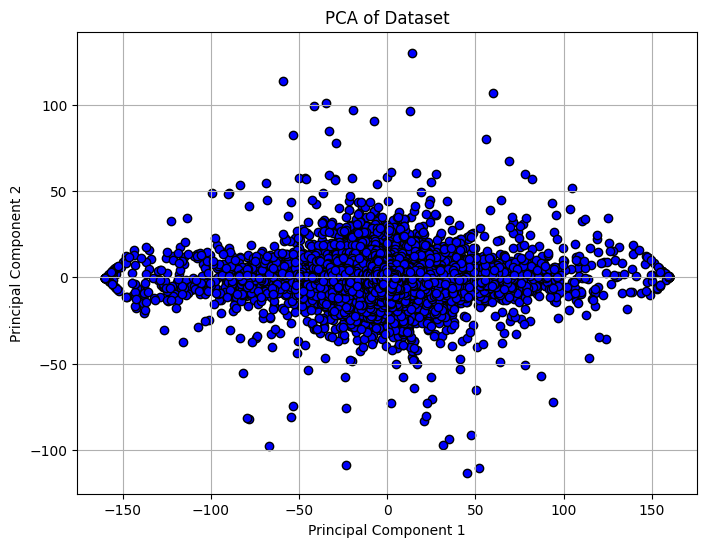

In [5]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


data_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/eeg/'

data = np.load(data_path + 'P03_01.npy')
labels_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/class_labels/'
labels = np.load(labels_path + 'group_P03_01.npy')

# Reshape to (468 * 4096, 64) for PCA across channels
data_reshaped = data.reshape(-1, 64)

# Apply PCA, reducing 64 channels to, for example, 10 components
pca = PCA(n_components=10)
data_pca = pca.fit_transform(data_reshaped)

# Reshape back to (468, 4096, 10) if you need to keep the temporal structure
data_pca_reshaped = data_pca.reshape(468, 4096, 10)

print(data_pca_reshaped.shape)  # Output: (468, 4096, 10)



# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='blue', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.grid()
plt.show()

### PCA Across Time

- Goal: Reduce the dimensionality of the time dimension (4096) while retaining the spatial structure (channels).
- Steps:
Reshape the data to combine the first two dimensions (samples and channels).
Apply PCA to reduce the time dimension.
Reshape the data back if needed.

(468, 64, 100)


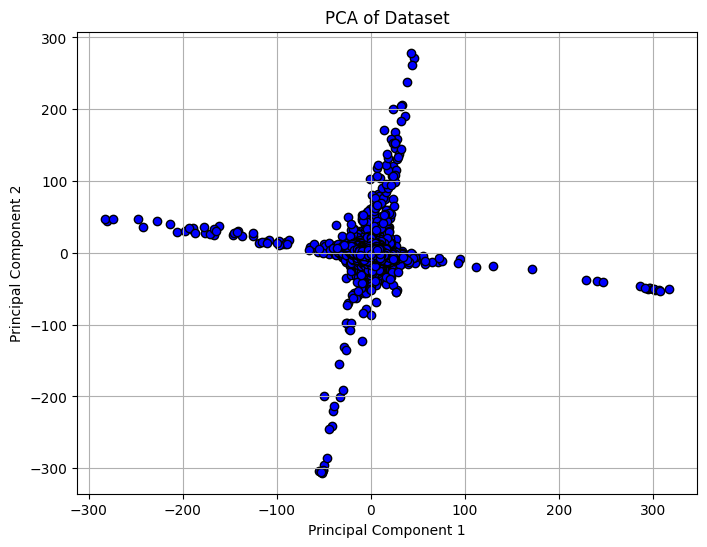

In [ ]:
import numpy as np
from sklearn.decomposition import PCA


# Reshape to (468 * 64, 4096) for PCA across time
data_reshaped = data.reshape(468 * 64, 4096)

# Apply PCA, reducing 4096 time points to, for example, 100 components
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_reshaped)

# Reshape back to (468, 64, 100) if you need to keep the spatial structure
data_pca_reshaped = data_pca.reshape(468, 64, 100)

print(data_pca_reshaped.shape)  # Output: (468, 64, 100)


# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='blue', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.grid()
plt.show()


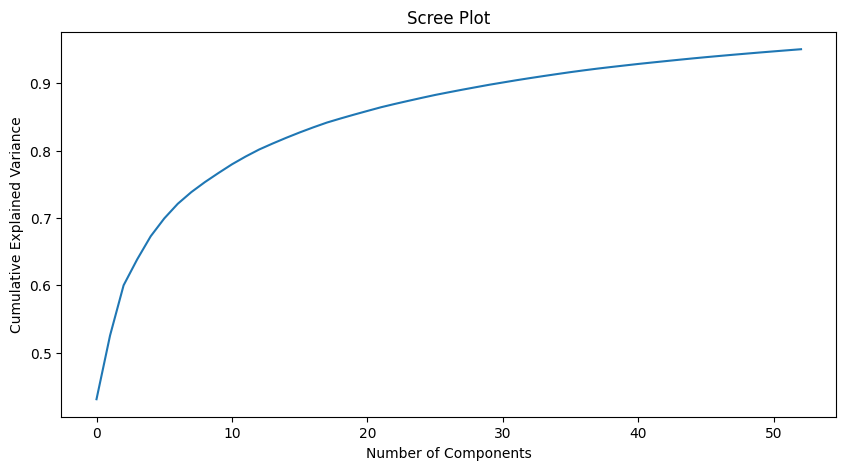

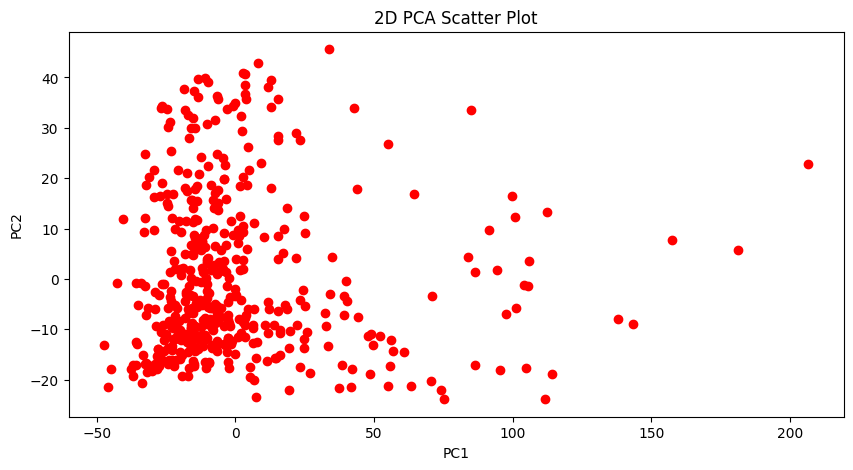

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'eeg_data' is your data matrix with shape (n_samples, n_channels)
# n_samples could be the number of time points or epochs, and n_channels is the number of EEG channels

# Standardize the data if necessary
eeg_data = (final_features - np.mean(final_features, axis=0)) / np.std(final_features, axis=0)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
principal_components = pca.fit_transform(final_features)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

# 2D scatter plot of the first two principal components
plt.figure(figsize=(10, 5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.title('2D PCA Scatter Plot')
plt.show()


### PCA for flattened data

Goal: Reduce the dimensionality of the entire dataset by treating it as a large feature vector.
Steps:
Flatten the data to combine all dimensions into one.
Apply PCA to reduce the overall dimensionality.

(468, 100)


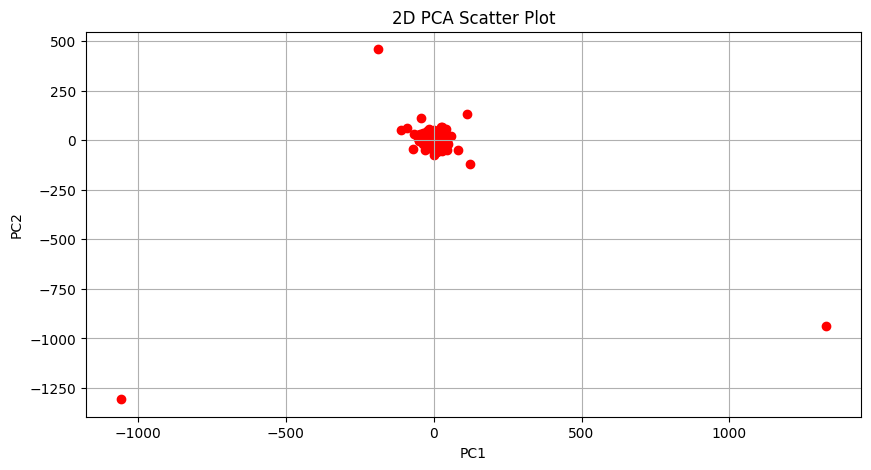

In [6]:
# Flatten the data to (468, 64 * 4096)
data_flattened = data.reshape(468, -1)

# Apply PCA to reduce the overall dimensionality
pca = PCA(n_components=100)  # Example: reduce to 100 components
data_pca = pca.fit_transform(data_flattened)

print(data_pca.shape)  # Output: (468, 100)

plt.figure(figsize=(10, 5))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.title('2D PCA Scatter Plot')
plt.show()



Filtered data shape: (465, 100)
Filtered labels shape: (465,)


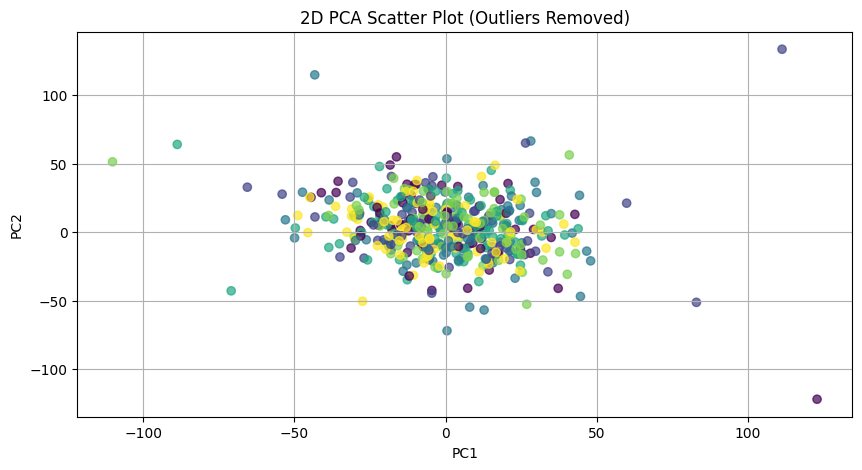

Original data shape: (468, 100)
Filtered data shape: (465, 100)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Define the range for PC1 and PC2 to keep
pc1_range = (-500, 500)
pc2_range = (-250, 250)

# Find the indices of the data points that fall within the specified ranges
valid_indices = np.where(
    (data_pca[:, 0] >= pc1_range[0]) & (data_pca[:, 0] <= pc1_range[1]) &
    (data_pca[:, 1] >= pc2_range[0]) & (data_pca[:, 1] <= pc2_range[1])
)[0]

# Filter the data based on these indices
data_pca_filtered = data_pca[valid_indices, :]

# Filter labels based on same indices
labels_filtered = labels[valid_indices]

# Ensure that the filtered labels correspond to the filtered data
print(f"Filtered data shape: {data_pca_filtered.shape}")  # Should be (N, 100)
print(f"Filtered labels shape: {labels_filtered.shape}")  # Should be (N,)


# Plot the filtered data
plt.figure(figsize=(10, 5))
plt.scatter(data_pca_filtered[:, 0], data_pca_filtered[:, 1], c=labels_filtered, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.title('2D PCA Scatter Plot (Outliers Removed)')
plt.show()

print(f"Original data shape: {data_pca.shape}")
print(f"Filtered data shape: {data_pca_filtered.shape}")


## Features

In [137]:
from scipy.signal import resample
import numpy as np
from scipy.signal import welch

#Get Data
# data_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/eeg/'

# data = np.load(data_path + 'P03_01.npy')


data = np.load('/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/Sven_Prp/eeg/eeg_P03_2D.npy')
labels = np.load('/Users/arnavkapur/Desktop/Analysis_3DImagery/imagery2024/PREPROCESSED_DATA/Sven_Prp/group_label/group_P03_2D.npy')


""" Use the first 500ms of the data and downsample it for classfiacation"""

# # Extract the first 256 samples (which corresponds to the first 500 ms)
# first_500ms_data = data[:, :, :256]
# print("New data shape:", first_500ms_data.shape)  # This should print (468, 64, 256)


# # # # Resample the data from 512 Hz to 256 Hz
# n_samples = data.shape[-1] // 2  # Divide the number of samples by 2 to downsample
# downsampled_data = resample(data, n_samples, axis=-1)
# print(downsampled_data.shape)
# data = downsampled_data

fs = 512

# Define frequency bands
delta_band = (1, 4)
theta_band = (4, 8)
alpha_band = (8, 12)
beta_band = (12, 30)
gamma_band = (30, 100)
sigma_band = (12, 16)




# Function to calculate band power
def bandpower(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=fs)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.mean(psd[idx_band])

# Calculate mean and peak frequency
def mean_and_peak_frequency(data, sf):
    freqs, psd = welch(data, sf, nperseg=fs)
    mean_freq = np.sum(freqs * psd) / np.sum(psd)
    peak_freq = freqs[np.argmax(psd)]
    return mean_freq, peak_freq

# Initialize feature arrays
mean_features = np.zeros((data.shape[0], data.shape[1]))
std_features = np.zeros((data.shape[0], data.shape[1]))
delta_band_features = np.zeros((data.shape[0], data.shape[1]))
theta_band_features = np.zeros((data.shape[0], data.shape[1]))
alpha_band_features = np.zeros((data.shape[0], data.shape[1]))
beta_band_features = np.zeros((data.shape[0], data.shape[1]))
gamma_band_features = np.zeros((data.shape[0], data.shape[1]))
sigma_band_features = np.zeros((data.shape[0], data.shape[1]))

mean_freq_features = np.zeros((data.shape[0], data.shape[1]))
peak_freq_features = np.zeros((data.shape[0], data.shape[1]))



## Alpha asymmetry
channel_pairs = [(0, 1)]  # Replace with actual pairs for your setup
alpha_asymmetry_features = np.zeros((data.shape[0], len(channel_pairs)))




# Set up wavelet scattering
# J max scale ogf wavelet transform
# # Q control the number of waveles per octave
# scattering = Scattering1D(J=6, shape=data.shape[2], Q=8)  # J is log2(N) with N=signal length =4096 -> Jmax = 12,
# example_input = data[0, 0, :]
# scattering_coeffs_example = scattering(example_input)
# scattering_features = np.zeros((data.shape[0], data.shape[1], scattering_coeffs_example.shape[0],scattering_coeffs_example.shape[1] ))


# Compute features per channel
for trial in range(data.shape[0]):
    for channel in range(data.shape[1]):
        channel_data = data[trial, channel, :]

        mean_features[trial, channel] = np.mean(channel_data)
        std_features[trial, channel] = np.std(channel_data)

        # Band intensities
        delta_band_features[trial, channel] = bandpower(channel_data, fs, delta_band)
        theta_band_features[trial, channel] = bandpower(channel_data, fs, theta_band)
        alpha_band_features[trial, channel] = bandpower(channel_data, fs, alpha_band)
        beta_band_features[trial, channel] = bandpower(channel_data, fs, beta_band)
        gamma_band_features[trial, channel] = bandpower(channel_data, fs, gamma_band)
        sigma_band_features[trial, channel] = bandpower(channel_data, fs, sigma_band)

         # Mean and peak frequency
        mean_freq_features[trial, channel], peak_freq_features[trial, channel] = mean_and_peak_frequency(channel_data, fs)


        # # Wavelet scattering
        # scattering_coeffs = scattering(channel_data)
        # scattering_features[trial, channel, :] = scattering_coeffs

         # Compute alpha asymmetry for defined channel pairs
    for idx, (ch1, ch2) in enumerate(channel_pairs):
        alpha_asymmetry_features[trial, idx] = alpha_band_features[trial, ch1] - alpha_band_features[trial, ch2]


combined_features = np.concatenate([
    mean_features,
    std_features,
    delta_band_features,
    theta_band_features,
    alpha_band_features,
    beta_band_features,
    gamma_band_features,
    sigma_band_features,
    mean_freq_features,
    peak_freq_features,
    alpha_asymmetry_features,
    # scattering_features.reshape(data.shape[0], -1)  # Flatten the scattering features
], axis=1)

print("Combined features shape:", combined_features.shape)

## alpha assymetry
## Mean and peak frequency




/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 512 is greater than input length  = 64, using nperseg = 64
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [78]:
import numpy as np
import pandas as pd

# Example array with NaN values


def interpolate_nan_rows(arr):
    df = pd.DataFrame(arr)
    # Interpolate NaN values row-wise
    df = df.interpolate(method='linear', axis=1, limit_direction='both')
    return df.to_numpy()

interpolated_features = interpolate_nan_rows(combined_features)


## Try Classificaiton for 2 classes


In [118]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load your features and labels
X_data = final_features
y_labels = labels

# Filter to include only two classes (e.g., classes 0 and 1)
selected_classes = [1,2]  # Replace these with the actual class labels you want to classify
filter_mask = np.isin(y_labels, selected_classes)

X_data_filtered = X_data[filter_mask]
y_labels_filtered = y_labels[filter_mask]

# Optionally, you can relabel the classes to be 0 and 1 if they aren't already
# y_labels_filtered = np.where(y_labels_filtered == selected_classes[0], 0, 1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data_filtered, y_labels_filtered, test_size=0.2, random_state=33, stratify=y_labels_filtered)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm.SVC(probability=True, class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

model = grid_search.best_estimator_

# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

loss = log_loss(y_test, y_pred_proba)
print(f"Loss: {loss:.6f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))


Exception ignored in: Exception ignored in: <generator object tqdm.__iter__ at 0x1445beb20>
Traceback (most recent call last):
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/notebook.py", line 178, in display
    pbar.bar_style = bar_style
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/traitlets/trait

Epoch 81: Train Loss: 1.333, Train Accuracy: 48.438, Val Loss: 1.904, Val Accuracy: 19.196

Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 58.97%
Loss: 0.663084
Confusion Matrix:
[[24 15]
 [17 22]]
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.62      0.60        39
           3       0.59      0.56      0.58        39

    accuracy                           0.59        78
   macro avg       0.59      0.59      0.59        78
weighted avg       0.59      0.59      0.59        78


## SVM

In [141]:
final_features.shape

(1170, 567)

In [165]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler




# labels_path = '/Users/arnavkapur/Desktop/Analysis_Imagery/imagery2024/PREPROCESSED_DATA/S01/class_labels/'
# labels = np.load(labels_path + 'group_P03_01.npy')
# # Load data
X_data = final_features
y_labels = labels

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.2, random_state=33, stratify=y_labels)

# X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_labels, test_size=0.3, random_state=42, stratify=y_labels)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm.SVC(probability=True, class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

model = grid_search.best_estimator_

# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

loss = log_loss(y_test, y_pred_proba)
print(f"Loss: {loss:.6f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 23.08%
Loss: 1.775007
Confusion Matrix:
[[ 6  9  4 10  6  4]
 [ 7 16  2  6  7  1]
 [ 4  7  5  7 10  6]
 [ 9  3  7  6  8  6]
 [ 7  7  7  5  6  7]
 [ 2  7  4  6  5 15]]
Classification Report:
              precision    recall  f1-score   support

           1       0.17      0.15      0.16        39
           2       0.33      0.41      0.36        39
           3       0.17      0.13      0.15        39
           4       0.15      0.15      0.15        39
           5       0.14      0.15      0.15        39
           6       0.38      0.38      0.38        39

    accuracy                           0.23       234
   macro avg       0.22      0.23      0.23       234
weighted avg       0.22      0.23      0.23       234


## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [500,1000],
    'penalty': ['l2']}

grid_search = GridSearchCV(LogisticRegression(multi_class='ovr', class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

model = grid_search.best_estimator_

# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

loss = log_loss(y_test, y_pred_proba)
print(f"Loss: {loss:.6f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
# plt.plot(fpr, tpr, marker='.')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/arnavkapur/.pyenv/

Best parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 29.79%
Loss: 3.551564
Confusion Matrix:
[[5 5 2 4 0 0]
 [4 5 2 0 2 2]
 [2 3 1 3 4 3]
 [1 0 4 7 1 3]
 [2 3 4 1 4 2]
 [1 3 3 1 1 6]]
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.31      0.32        16
           2       0.26      0.33      0.29        15
           3       0.06      0.06      0.06        16
           4       0.44      0.44      0.44        16
           5       0.33      0.25      0.29        16
           6       0.38      0.40      0.39        15

    accuracy                           0.30        94
   macro avg       0.30      0.30      0.30        94
weighted avg       0.30      0.30      0.30        94

ROC-AUC Score: 0.67


## Random Forest Classificaiton

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
X_data = combined_features
y_labels = labels

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.2, random_state=33, stratify=y_labels)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=33), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

model = grid_search.best_estimator_

# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

loss = log_loss(y_test, y_pred_proba)
print(f"Loss: {loss:.6f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 30.85%
Loss: 1.665736
Confusion Matrix:
[[8 1 0 1 6 0]
 [3 3 4 1 3 1]
 [1 1 1 0 7 6]
 [3 0 2 5 2 4]
 [5 3 0 1 4 3]
 [2 0 1 1 3 8]]
Classification Report:
              precision    recall  f1-score   support

           1       0.36      0.50      0.42        16
           2       0.38      0.20      0.26        15
           3       0.12      0.06      0.08        16
           4       0.56      0.31      0.40        16
           5       0.16      0.25      0.20        16
           6       0.36      0.53      0.43        15

    accuracy                           0.31        94
   macro avg       0.32      0.31      0.30        94
weighted avg       0.32      0.31      0.30        94


## Play with EEG GAN - feature extraction Model

In [ ]:
!pip install tensorflow-addons
!pip install tensorflow-addons==0.21.0
!pip install kymatio
!pip install keras==2.14.0
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD, RMSprop
import tensorflow as tf
from tensorflow.keras import Model, models, layers, regularizers
import tensorflow_addons as tfa

weight_decay = 1e-4

def enc_conv_block(filters, kernel, strides, padding, rate):
	return models.Sequential([
			layers.Conv1D(filters=filters, kernel_size=kernel, strides=strides, padding=padding),
			layers.Activation(activation='leaky_relu'),
			layers.BatchNormalization(),
			layers.Dropout(rate=rate)
		])


class TripleNet(Model):
	def __init__(self, n_classes=10, n_features=128):
		super(TripleNet, self).__init__()
		# filters   = [ 8,  16,  n_features]
		# ret_seq   = [ True, True, False]
		filters   = [ 32,  n_features]
		ret_seq   = [ True, False]
		# strides = [ 1,   2,  2,   2,]
		# kernel  = [ 7,   7,  3,   3,]
		# padding = ['same', 'same', 'same', 'same']
		self.enc_depth  = len(filters)
		# self.encoder    = [enc_conv_block(filters[idx], kernel[idx], strides[idx], padding[idx], rate=0.1) for idx in range(self.enc_depth)]
		self.encoder   = [layers.LSTM(units=filters[idx], return_sequences=ret_seq[idx]) for idx in range(self.enc_depth)]
		self.flat      = layers.Flatten()
		self.w_1       = layers.Dense(units=n_features, activation='leaky_relu')
		self.w_2       = layers.Dense(units=n_features)
		# self.feat_norm  = layers.BatchNormalization()
		# self.cls_layer  = layers.Dense(units=n_classes, kernel_regularizer=regularizers.l2(weight_decay))

	def call(self, x):
		for idx in range(self.enc_depth):
			x = self.encoder[idx]( x )
		# print(x.shape)
		x = feat = self.flat( x )
		# print(x.shape)
		# x = feat = self.feat_layer( x )
		# print(x.shape)
		# x = self.feat_norm( x )
		# x = self.cls_layer(x)
		# x = self.w_2( self.w_1( x ) )
		x = tf.nn.l2_normalize(x, axis=-1)

		return x, feat

@tf.function
def train_step(softnet, opt, X, Y):
	with tf.GradientTape() as tape:
		Y_emb, _ = softnet(X, training=True)
		# loss  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(Y, Y_emb)
		loss  = tfa.losses.TripletSemiHardLoss()(Y, Y_emb)
	variables = softnet.trainable_variables
	gradients = tape.gradient(loss, variables)
	opt.apply_gradients(zip(gradients, variables))
	return loss

@tf.function
def test_step(softnet, X, Y):
	Y_emb, _ = softnet(X, training=False)
	loss  = tfa.losses.TripletSemiHardLoss()(Y, Y_emb)
	# loss  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(Y, Y_emb)
	return loss

## ACT MODEL

In [ ]:
""" 
Copyright (C) 2022 King Saud University, Saudi Arabia 
SPDX-License-Identifier: Apache-2.0 

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the 
License at

http://www.apache.org/licenses/LICENSE-2.0  

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR 
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License. 

Author:  Hamdi Altaheri 
"""

##%%
import math
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense
from tensorflow.keras.layers import multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras.layers import Dropout, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras import backend as K


##%% Create and apply the attention model
def attention_block(in_layer, attention_model, ratio=8, residual = False, apply_to_input=True): 
    in_sh = in_layer.shape # dimensions of the input tensor
    in_len = len(in_sh) 
    expanded_axis = 2 # defualt = 2
    
    if attention_model == 'mha':   # Multi-head self attention layer 
        if(in_len > 3):
            in_layer = Reshape((in_sh[1],-1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer 
        if(in_len > 3):
            in_layer = Reshape((in_sh[1],-1))(in_layer)
        out_layer = mha_block(in_layer, vanilla = False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if(in_len < 4):
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional block attention module
        if(in_len < 4):
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual = residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))
        
    if (in_len == 3 and len(out_layer.shape) == 4):
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif (in_len == 4 and len(out_layer.shape) == 3):
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer


##%% Multi-head self Attention (MHA) block
def mha_block(input_feature, key_dim=8, num_heads=2, dropout = 0.5, vanilla = True):
    """Multi Head self Attention (MHA) block.     
       
    Here we include two types of MHA blocks: 
            The original multi-head self-attention as described in https://arxiv.org/abs/1706.03762
            The multi-head local self attention as described in https://arxiv.org/abs/2112.13492v1
    """    
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    
    if vanilla:
        # Create a multi-head attention layer as described in 
        # 'Attention Is All You Need' https://arxiv.org/abs/1706.03762
        x = MultiHeadAttention(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(x, x)
    else:
        # Create a multi-head local self-attention layer as described in 
        # 'Vision Transformer for Small-Size Datasets' https://arxiv.org/abs/2112.13492v1
        
        # Build the diagonal attention mask
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        
        # Create a multi-head local self attention layer.
        # x = MultiHeadAttention_LSA(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(
        #     x, x, attention_mask = diag_attn_mask)
        x = MultiHeadAttention_LSA(key_dim = key_dim, num_heads = num_heads, dropout = dropout)(
            x, x, attention_mask = diag_attn_mask)
    x = Dropout(0.3)(x)
    # Skip connection
    mha_feature = Add()([input_feature, x])
    
    return mha_feature


##%% Multi head self Attention (MHA) block: Locality Self Attention (LSA)
class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """local multi-head self attention block
     
     Locality Self Attention as described in https://arxiv.org/abs/2112.13492v1
     This implementation is taken from  https://keras.io/examples/vision/vit_small_ds/ 
    """    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is the square 
        # root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


##%% Squeeze-and-excitation block
def se_block(input_feature, ratio=8, residual = False, apply_to_input=True):
    """Squeeze-and-Excitation(SE) block.
    
    As described in https://arxiv.org/abs/1709.01507
    The implementation is taken from https://github.com/kobiso/CBAM-keras
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    assert se_feature.shape[1:] == (1,1,channel)
    if (ratio != 0):
        se_feature = Dense(channel // ratio,
                           activation='relu',
                           kernel_initializer='he_normal',
                           use_bias=True,
                           bias_initializer='zeros')(se_feature)
        assert se_feature.shape[1:] == (1,1,channel//ratio)
    se_feature = Dense(channel,
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1,1,channel)
    if K.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
        
    if(apply_to_input):
        se_feature = multiply([input_feature, se_feature])
    
    # Residual Connection
    if(residual): 
        se_feature = Add()([se_feature, input_feature])

    return se_feature


##%% Convolutional block attention module
def cbam_block(input_feature, ratio=8, residual = False):
    """ Convolutional Block Attention Module(CBAM) block.
    
    As described in https://arxiv.org/abs/1807.06521
    The implementation is taken from https://github.com/kobiso/CBAM-keras
    """
    
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    
    # Residual Connection
    if(residual): 
        cbam_feature = Add()([input_feature, cbam_feature])

    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
#     channel = input_feature._keras_shape[channel_axis]
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)    
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])
        
    

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Permute, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, AveragePooling2D, Dropout, Lambda, Dense, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.constraints import max_norm

# from attention_models import attention_block  # Assuming attention_block is defined in another module

class ATCNet(Model):
    def __init__(self, n_classes=6, in_chans=64, in_samples=4096, n_windows=5, attention='mha',
                 eegn_F1=16, eegn_D=2, eegn_kernelSize=256, eegn_poolSize=7, eegn_dropout=0.5,
                 tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3,
                 tcn_activation='elu', fuse='average', dense_weightDecay=0.5, conv_weightDecay=0.009, 
                 conv_maxNorm=0.6, from_logits=False):
        super(ATCNet, self).__init__()
        self.n_classes = n_classes
        self.n_windows = n_windows
        self.attention = attention
        self.fuse = fuse
        self.from_logits = from_logits
        
        # Convolutional block parameters
        self.eegn_F1 = eegn_F1
        self.eegn_D = eegn_D
        self.eegn_kernelSize = eegn_kernelSize
        self.eegn_poolSize = eegn_poolSize
        self.eegn_dropout = eegn_dropout
        self.conv_weightDecay = conv_weightDecay
        self.conv_maxNorm = conv_maxNorm
        
        # Temporal convolutional block parameters
        self.tcn_depth = tcn_depth
        self.tcn_kernelSize = tcn_kernelSize
        self.tcn_filters = tcn_filters
        self.tcn_dropout = tcn_dropout
        self.tcn_activation = tcn_activation
        
        # Dense layer regularization
        self.dense_weightDecay = dense_weightDecay
        
        # Input layers
        self.input_1 = Input(shape=(1, in_chans, in_samples))
        self.input_2 = Permute((3, 2, 1))(self.input_1)
        
        # Layers
        self.block1 = self.build_conv_block()
        
    def build_conv_block(self):
        F2 = self.eegn_F1 * self.eegn_D
        block1 = Conv2D(self.eegn_F1, (self.eegn_kernelSize, 1), padding='same', data_format='channels_last',
                        kernel_regularizer=L2(self.conv_weightDecay),
                        kernel_constraint=max_norm(self.conv_maxNorm, axis=[0, 1, 2]),
                        use_bias=False)(self.input_2)
        block1 = BatchNormalization(axis=-1)(block1)
        
        block2 = DepthwiseConv2D((1, 64), depth_multiplier=self.eegn_D, data_format='channels_last',
                                 depthwise_regularizer=L2(self.conv_weightDecay),
                                 depthwise_constraint=max_norm(self.conv_maxNorm, axis=[0, 1, 2]),
                                 use_bias=False)(block1)
        block2 = BatchNormalization(axis=-1)(block2)
        block2 = Activation('elu')(block2)
        block2 = AveragePooling2D((8, 1), data_format='channels_last')(block2)
        block2 = Dropout(self.eegn_dropout)(block2)
        
        block3 = Conv2D(F2, (16, 1), data_format='channels_last', use_bias=False, padding='same',
                        kernel_regularizer=L2(self.conv_weightDecay),
                        kernel_constraint=max_norm(self.conv_maxNorm, axis=[0, 1, 2]))(block2)
        block3 = BatchNormalization(axis=-1)(block3)
        block3 = Activation('elu')(block3)
        block3 = AveragePooling2D((self.eegn_poolSize, 1), data_format='channels_last')(block3)
        block3 = Dropout(self.eegn_dropout)(block3)
        
        return Lambda(lambda x: x[:, :, -1, :])(block3)
    
    def call(self, inputs):
        block1_output = self.block1(inputs)
        
        sw_concat = []
        for i in range(self.n_windows):
            st = i
            end = block1_output.shape[1] - self.n_windows + i + 1
            block2 = block1_output[:, st:end, :]
            
            if self.attention is not None:
                if self.attention in ['se', 'cbam']:
                    block2 = Permute((2, 1))(block2)
                    block2 = attention_block(block2, self.attention)
                    block2 = Permute((2, 1))(block2)
                else:
                    block2 = attention_block(block2, self.attention)
            
            block3 = self.build_tcn_block(block2)
            block3 = Lambda(lambda x: x[:, -1, :])(block3)
            
            if self.fuse == 'average':
                sw_concat.append(Dense(self.n_classes, kernel_regularizer=L2(self.dense_weightDecay))(block3))
            elif self.fuse == 'concat':
                if i == 0:
                    sw_concat = block3
                else:
                    sw_concat = Concatenate()([sw_concat, block3])
        
        if self.fuse == 'average':
            if len(sw_concat) > 1:
                sw_concat = tf.keras.layers.Average()(sw_concat[:])
            else:
                sw_concat = sw_concat[0]
        elif self.fuse == 'concat':
            sw_concat = Dense(self.n_classes, kernel_regularizer=L2(self.dense_weightDecay))(sw_concat)
        
        if self.from_logits:
            out = Activation('linear', name='linear')(sw_concat)
        else:
            out = Activation('softmax', name='softmax')(sw_concat)
        
        return out
    
    def build_tcn_block(self, input_layer):
        block = Conv1D(self.tcn_filters, kernel_size=self.tcn_kernelSize, dilation_rate=1, activation='linear',
                       kernel_regularizer=L2(self.conv_weightDecay),
                       kernel_constraint=max_norm(self.conv_maxNorm, axis=[0, 1]),
                       padding='causal', kernel_initializer='he_uniform')(input_layer)
        block = BatchNormalization()(block)
        block = Activation(self.tcn_activation)(block)
        block = Dropout(self.tcn_dropout)(block)
        
        for i in range(self.tcn_depth - 1):
            block = Conv1D(self.tcn_filters, kernel_size=self.tcn_kernelSize, dilation_rate=2**(i+1), activation='linear',
                           kernel_regularizer=L2(self.conv_weightDecay),
                           kernel_constraint=max_norm(self.conv_maxNorm, axis=[0, 1]),
                           padding='causal', kernel_initializer='he_uniform')(block)
            block = BatchNormalization()(block)
            block = Activation(self.tcn_activation)(block)
            block = Dropout(self.tcn_dropout)(block)
        
        return block

# Usage example:
# model = ATCNet()
# model.build(input_shape=(None, 1, 64, 4096))
# model.summary()


In [ ]:
"""Initialize the Model"""
model_02 = ATCNet(
      n_classes=6,
      in_chans=64, 
      in_samples=4096, 
      n_windows=5, 
      attention='mha',
      eegn_F1=16, 
      eegn_D=2, 
      eegn_kernelSize=256, 
      eegn_poolSize=7, 
      eegn_dropout=0.5,
      tcn_depth=2, 
      tcn_kernelSize=4, 
      tcn_filters=32, 
      tcn_dropout=0.3,
      tcn_activation='elu', 
      fuse='average', 
      dense_weightDecay=0.5, 
      conv_weightDecay=0.009, 
      conv_maxNorm=0.6, 
      from_logits=False)

"""Set up dataset"""


## Cross Validation

from sklearn.model_selection import cross_val_score
from sklearn import metrics
